In [112]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Point to the parent folder (KALMAN-HESTON-FILTER)
current_dir = Path.cwd()
parent_dir = current_dir.parent
sys.path.insert(0, str(parent_dir))

# Now Python sees "model" as a valid package
from model.kalman_heston_filter import kalman_like_heston_filter, estimate_params_qmle
from model.heston_mod import heston_DGP
from simulation.sim_heston_kalman import plot_heston_vs_kalman

## Initialization

In [5]:
# True parameters for the simulated Heston model (unknown in estimation):
true_params = {
    "alpha": 0.1,
    "beta": 0.9, 
    "gamma": 0.3,
    "delta": 0.2
}
T = 1000           # Number of observations for estimation.
burn_in = 100      # Burn-in period.

# Arbitrary diffusion starting value (since we don't know the true V):
V0_initial = 10.0   # Use this as initial guess for the latent state in filtering
P0_init = 0.1       # Initial filtering uncertainty

## Heston model DGP

In [17]:
# Simulate the Heston model (the "real" data)
noise_t = {'df': 2.5}
noise_par = {'alpha': 2.5}

V_series_norm, y_series_norm = heston_DGP(T, **true_params, V0=V0_initial, seed=42, noise_dist='normal', burn_in=burn_in)
V_series_t, y_series_t       = heston_DGP(T, **true_params, V0=V0_initial, seed=42, noise_dist='t', noise_params=noise_t, burn_in=burn_in)
V_series_par, y_series_par   = heston_DGP(T, **true_params, V0=V0_initial, seed=42, noise_dist='pareto', noise_params=noise_par, burn_in=burn_in)

## Estimation 
### 1. QMLE

In [22]:
# QMLE Estimation: Start with an initial guess reflecting a diffusion process.
init_guess = np.array([0.5, 0.5, 0.5, 0.5])
bounds = [
    (1e-8, None),      # alpha >= 0
    (1e-8, 1 - 1e-8),  # 0 < beta < 1
    (1e-8, None),      # gamma >= 0
    (1e-8, None)       # delta >= 0
]

result_norm = estimate_params_qmle(y_series_norm, V0=V0_initial, P0=P0_init, init_params=init_guess)
result_t    = estimate_params_qmle(y_series_t, V0=V0_initial, P0=P0_init, init_params=init_guess)
result_par  = estimate_params_qmle(y_series_par, V0=V0_initial, P0=P0_init, init_params=init_guess)

estimated_params_norm = result_norm.x
estimated_params_t    = result_t.x
estimated_params_par  = result_par.x

In [23]:
print(f"True parameters:     {list(true_params.values())}")
print(f"Normal distribution: {estimated_params_norm}")
print(f"t-distribution:      {estimated_params_t}")
print(f"Pareto distribution: {estimated_params_par}")

True parameters:     [0.1, 0.9, 0.3, 0.2]
Normal distribution: [0.12660115 0.87857984 0.35029674 0.14560793]
t-distribution:      [0.40719219 0.45153378 0.32851955 0.3022408 ]
Pareto distribution: [0.11812652 0.87805345 0.27884361 0.11404195]


## Kalman-like Heston filter

In [24]:
# Now use the estimated parameters in the Kalman filter
V_pred_norm, P_pred_norm, V_filt_norm, P_filt_norm = kalman_like_heston_filter(y_series_norm, *estimated_params_norm, V0=V0_initial, P0=P0_init)
V_pred_t, P_pred_t, V_filt_t, P_filt_t = kalman_like_heston_filter(y_series_t, *estimated_params_t, V0=V0_initial, P0=P0_init)
V_pred_par, P_pred_par, V_filt_par, P_filt_par = kalman_like_heston_filter(y_series_par, *estimated_params_par, V0=V0_initial, P0=P0_init)

## Plot

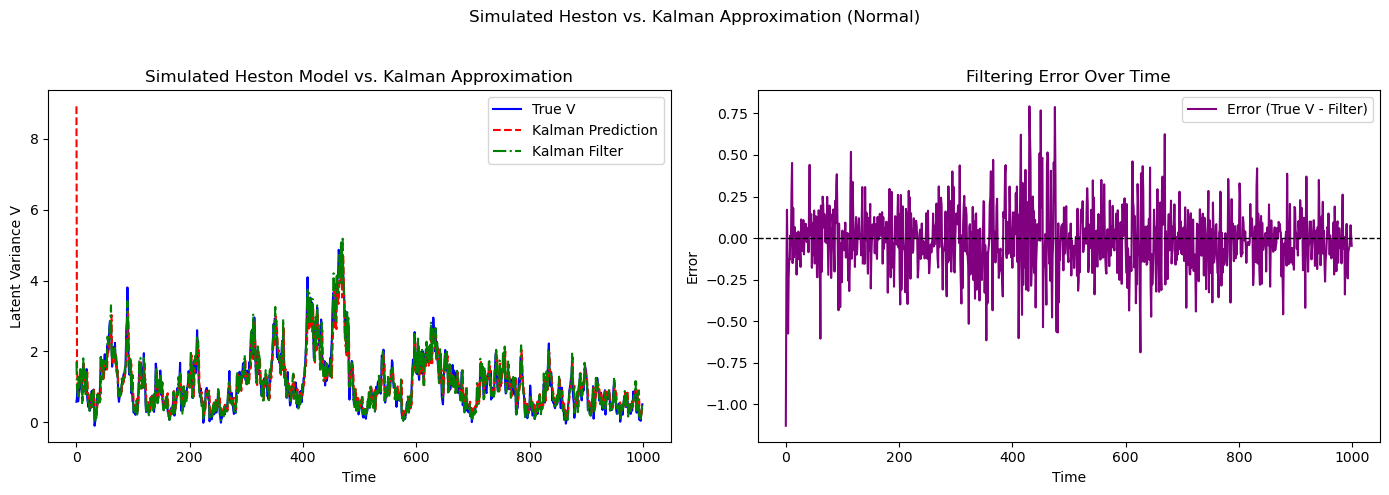

In [25]:
# Plot the simulated Heston process vs. the Kalman approximation 
plot_heston_vs_kalman(V_series_norm, V_pred_norm, V_filt_norm, title="Simulated Heston vs. Kalman Approximation (Normal)")

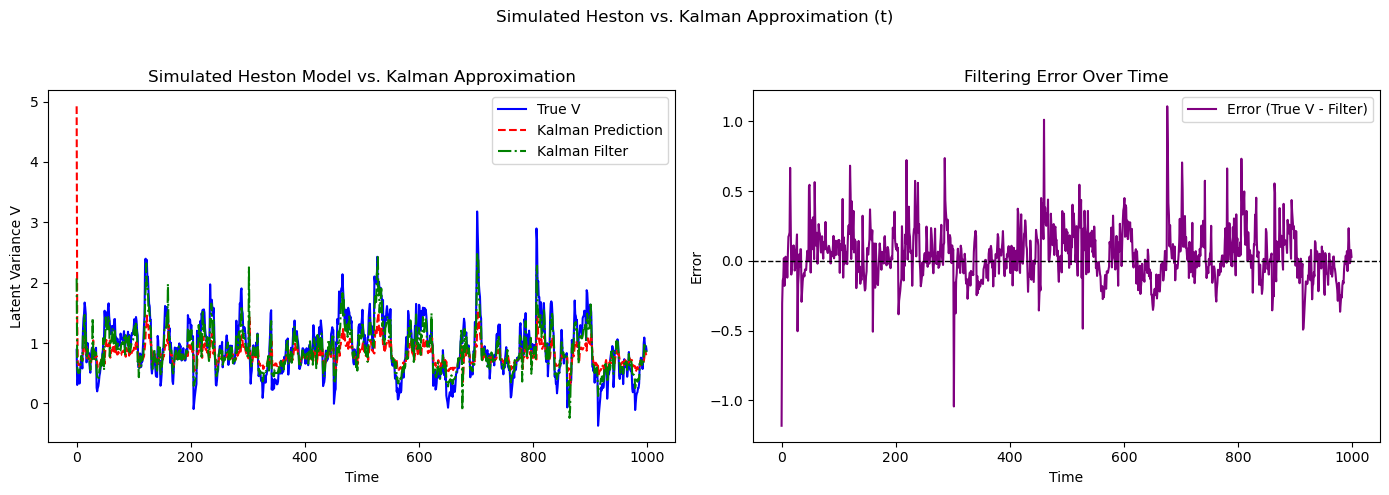

In [26]:
# Plot the simulated Heston process vs. the Kalman approximation 
plot_heston_vs_kalman(V_series_t, V_pred_t, V_filt_t, title="Simulated Heston vs. Kalman Approximation (t)")

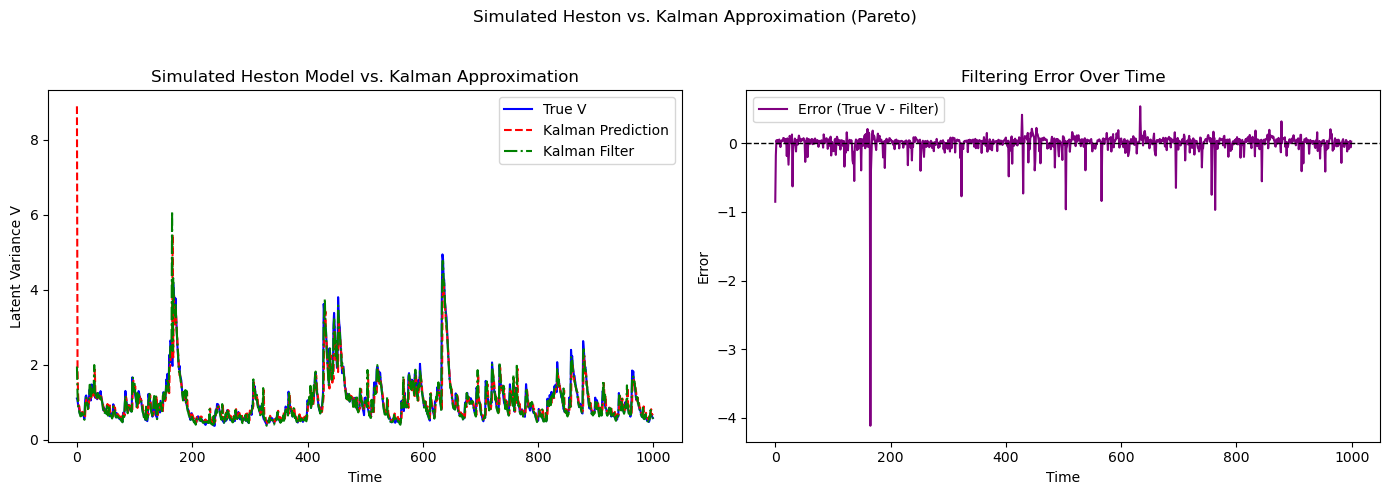

In [27]:
# Plot the simulated Heston process vs. the Kalman approximation 
plot_heston_vs_kalman(V_series_par, V_pred_par, V_filt_par, title="Simulated Heston vs. Kalman Approximation (Pareto)")

## Forecast

1. One-step-ahead forecast

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

# 1. Split data and estimate Heston filter parameters
train_ratio = 0.70  
n = len(y_series_norm)
split_index = int(n * train_ratio)

# Split the time series data into training and test sets
y_train_norm = y_series_norm[:split_index]
y_test_norm  = y_series_norm[split_index:]

# Parameter estimation using QMLE on the training set for Heston filter
result_train_norm = estimate_params_qmle(y_train_norm, V0=V0_initial, P0=P0_init, init_params=init_guess)
estimated_params_train_norm = result_train_norm.x

# Run the Kalman-like Heston filter on the training set
V_pred_train_norm, P_pred_train_norm, V_filt_train_norm, P_filt_train_norm = kalman_like_heston_filter(y_train_norm, *estimated_params_train_norm, V0=V0_initial, P0=P0_init)

# Use the last filtered state and covariance from training for forecast initialization
V0_forecast = V_filt_train_norm[-1]
P0_forecast = P_filt_train_norm[-1]

# For out-of-sample one-step-ahead forecasting using the Heston filter,
# re-run the filter on the test set starting from the forecast initialization.
V_pred_test_norm, P_pred_test_norm, V_filt_test_norm, P_filt_test_norm = kalman_like_heston_filter(y_test_norm, *estimated_params_train_norm, V0=V0_forecast, P0=P0_forecast)

/var/folders/l6/j16k6g014qz2cd2jn1j0m9d40000gn/T/ipykernel_85472/2656796384.py:14: RuntimeWarning: invalid value encountered in sqrt
  vol_true            = np.sqrt(V_true_test_aligned)


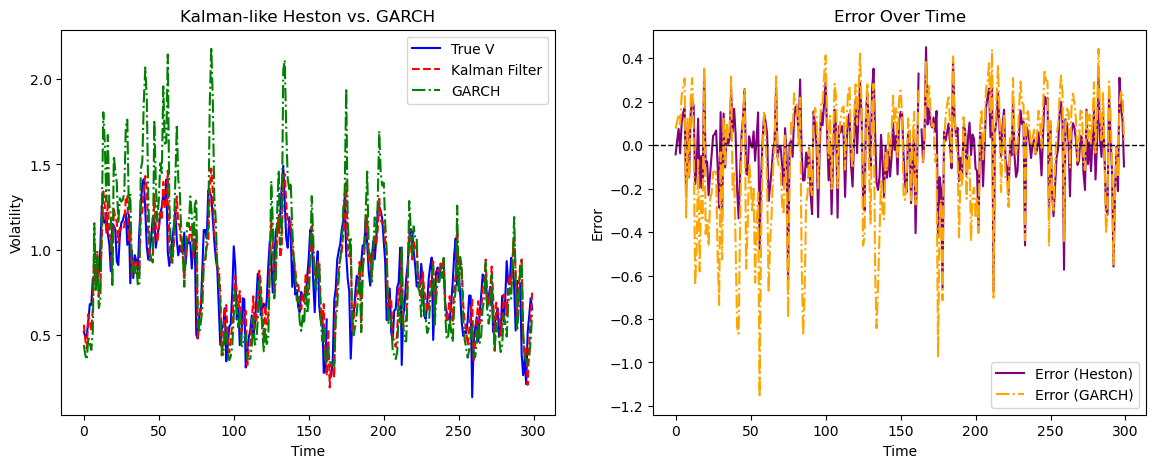

In [ ]:
garch_model = arch_model(y_series_norm, vol='Garch', p=1, q=1, mean='Zero', dist='normal')
garch_fit = garch_model.fit(last_obs=split_index-1, disp='off')

# Generate one-step-ahead forecasts for the test set.
garch_forecasts = garch_fit.forecast(horizon=1, start=split_index, reindex=False)

# Extract the one-step-ahead forecast variance.
garch_var_forecast = garch_forecasts.variance['h.1'].values.flatten()
V_true_test_aligned = V_series_norm[split_index+1:]

# Convert variances to volatility forecasts (by taking the square root)
vol_forecast_heston = np.sqrt(V_filt_test_norm)
vol_forecast_garch  = np.sqrt(garch_var_forecast)
vol_true            = np.sqrt(V_true_test_aligned)

# Create two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

time = np.arange(1000-split_index)
# Left plot: True latent state vs. Kalman prediction and filtered estimates
axs[0].plot(time, vol_true, label="True V", color="blue")
axs[0].plot(time, vol_forecast_heston, label="Kalman Filter", linestyle="--", color="red")
axs[0].plot(time, vol_forecast_garch, label="GARCH", linestyle="-.", color="green")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Volatility")
axs[0].set_title("Kalman-like Heston vs. GARCH (normal noise)")
axs[0].legend()

# Right plot: Filtering error over time
# (difference between the true latent state and the filtered estimate)
error_heston = vol_true - vol_forecast_heston
error_garch = vol_true - vol_forecast_garch
axs[1].plot(time, error_heston, label="Error (Heston)", linestyle="-", color="purple")
axs[1].plot(time, error_garch, label="Error (GARCH)", linestyle="-.", color="orange")
axs[1].axhline(0, color="black", linewidth=1, linestyle="--")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Error")
axs[1].set_title("Error Over Time")
axs[1].legend()

In [113]:
# Compute the mean absolute error (MAE) using the aligned true volatility.
heston_mae = pd.DataFrame(np.abs(vol_forecast_heston - vol_true)).mean()
garch_mae  = pd.DataFrame(np.abs(vol_forecast_garch - vol_true)).mean()

print("Heston Filter Volatility MAE:", heston_mae)
print("GARCH Volatility MAE:", garch_mae)

Heston Filter Volatility MAE: 0    0.136105
dtype: float64
GARCH Volatility MAE: 0    0.22012
dtype: float64


In [39]:
def predict_step_heston(V, P, alpha, beta, gamma, delta):
    """
    Compute the one-step prediction of the Heston filter state and covariance,
    using the same transition dynamics as defined in kalman_like_heston_filter.
    
    Parameters:
        V (float): Current filtered variance state.
        P (float): Current filtered covariance.
        alpha (float): Intercept parameter in the state transition.
        beta (float): Slope parameter in the state transition.
        gamma (float): Scaling parameter for the state-dependent process noise.
        delta (float): Additive constant for the process noise variance.
    
    Returns:
        V_pred (float): Predicted state for the next time step.
        P_pred (float): Predicted covariance for the next time step.
        
    Equations:
        V_pred = alpha + beta * V
        Q = gamma^2 * V + delta
        P_pred = beta^2 * P + Q
    """
    # State prediction: linear transition of the variance state
    V_pred = alpha + beta * V

    # Process noise variance (heteroskedastic, depends on current state)
    Q = gamma**2 * V + delta

    # Covariance prediction: propagate uncertainty through the state transition
    P_pred = beta**2 * P + Q

    return V_pred, P_pred

def multi_step_ahead_forecast_heston(V0, P0, alpha, beta, gamma, delta, x_steps):
    """
    Produce x-step-ahead forecasts for the Heston state using the discrete-time
    prediction equations defined in the attached Kalman filter code.
    
    Parameters:
        V0 (float): Last filtered state (variance) from training.
        P0 (float): Last filtered covariance from training.
        alpha, beta, gamma, delta (floats): Heston-like parameters (estimated).
        x_steps (int): Forecast horizon (number of steps ahead to forecast).
        
    Returns:
        V_forecasts (np.ndarray): Array of shape (x_steps,) containing the predicted
                                  variance states for each forecast step.
        P_forecasts (np.ndarray): Array of shape (x_steps,) containing the predicted
                                  covariances for each forecast step.
    """
    V_forecasts = np.zeros(x_steps)
    P_forecasts = np.zeros(x_steps)

    # Initialize the forecast state with the last filtered state/covariance.
    V_current = V0
    P_current = P0

    for i in range(x_steps):
        # Perform the time update (prediction step) without measurement update.
        V_current, P_current = predict_step_heston(V_current, P_current, alpha, beta, gamma, delta)
        V_forecasts[i] = V_current
        P_forecasts[i] = P_current

    return V_forecasts, P_forecasts

# Example usage:
# Assume these variables are defined as per your workflow:
#   V0_forecast and P0_forecast come from the last filtered values from the training set.
#   estimated_params_train_norm = [alpha, beta, gamma, delta] are the QMLE estimates.

x_steps = 5  # For instance, a 5-step-ahead forecast

V_multi_fore, P_multi_fore = multi_step_ahead_forecast_heston(
    V0_forecast,
    P0_forecast,
    *estimated_params_train_norm,  # This unpacks alpha, beta, gamma, delta
    x_steps
)

print("Multi-step-ahead predicted variances:", V_multi_fore)
print("Multi-step-ahead predicted covariances:", P_multi_fore)


Multi-step-ahead predicted variances: [0.52687089 0.59956326 0.6641218  0.72145662 0.77237603]
Multi-step-ahead predicted covariances: [0.20324786 0.36999159 0.51186642 0.63296727 0.73665363]


Step-ahead forecast vs. true values:
Step 1: Forecast = 0.5269, True = 0.4064
Step 2: Forecast = 0.5996, True = 0.4897
Step 3: Forecast = 0.6641, True = 0.5664
Step 4: Forecast = 0.7215, True = 0.6208
Step 5: Forecast = 0.7724, True = 0.4928
Step 6: Forecast = 0.8176, True = 0.2481
Step 7: Forecast = 0.8578, True = 0.1374
Step 8: Forecast = 0.8934, True = 0.1438
Step 9: Forecast = 0.9251, True = 0.1959
Step 10: Forecast = 0.9532, True = 0.1869
Step 11: Forecast = 0.9782, True = 0.1598
Step 12: Forecast = 1.0004, True = 0.1014
Step 13: Forecast = 1.0201, True = 0.2518
Step 14: Forecast = 1.0376, True = 0.2987
Step 15: Forecast = 1.0532, True = 0.3761
Step 16: Forecast = 1.0670, True = 0.6158
Step 17: Forecast = 1.0792, True = 0.5230
Step 18: Forecast = 1.0901, True = 0.5515
Step 19: Forecast = 1.0998, True = 0.4173
Step 20: Forecast = 1.1084, True = 0.8007
Step 21: Forecast = 1.1160, True = 0.9734
Step 22: Forecast = 1.1228, True = 0.8638
Step 23: Forecast = 1.1288, True = 0.7153
Step 2

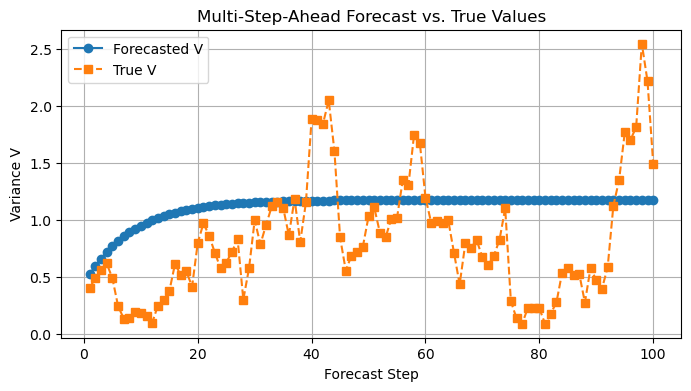

In [40]:
# Assuming the following variables are defined:
#   y_series_norm, V_series_norm: the simulated observation and true state series.
#   V0_initial, P0_init: initial conditions.
#   init_guess: initial guess for QMLE.
#   estimated_params_train_norm: the estimated parameters [alpha, beta, gamma, delta]
#   kalman_like_heston_filter: your filter function.
#   multi_step_ahead_forecast_heston, predict_step_heston: functions defined earlier.

# Set the train-test split
train_ratio = 0.50  # 50% training, 50% testing
n = len(y_series_norm)
split_index = int(n * train_ratio)

# Split the observation data into training and test sets
y_train_norm = y_series_norm[:split_index]
y_test_norm  = y_series_norm[split_index:]

# Parameter estimation using QMLE on the training set
result_train_norm = estimate_params_qmle(
    y_train_norm,
    V0=V0_initial,
    P0=P0_init,
    init_params=init_guess
)
estimated_params_train_norm = result_train_norm.x

# Run the filter on the training set
V_pred_train_norm, P_pred_train_norm, V_filt_train_norm, P_filt_train_norm = \
    kalman_like_heston_filter(
        y_train_norm,
        *estimated_params_train_norm,
        V0=V0_initial,
        P0=P0_init
    )

# Use the last filtered state from the training period for forecast initialization
V0_forecast = V_filt_train_norm[-1]
P0_forecast = P_filt_train_norm[-1]

# Choose a forecast horizon, e.g., 5 steps ahead
x_steps = 100

# Compute the multi-step-ahead forecast from the last training point
V_multi_fore, P_multi_fore = multi_step_ahead_forecast_heston(
    V0_forecast,
    P0_forecast,
    *estimated_params_train_norm,  # unpacks alpha, beta, gamma, delta
    x_steps
)

# Extract the true underlying variance values for the forecast horizon
# Assuming that the true state series V_series_norm aligns with y_series_norm:
V_true_forecast = V_series_norm[split_index:split_index + x_steps]

# Print out the forecast and true values for each step
print("Step-ahead forecast vs. true values:")
for i in range(x_steps):
    print(f"Step {i+1}: Forecast = {V_multi_fore[i]:.4f}, True = {V_true_forecast[i]:.4f}")

# Optionally, plot the forecast against the true values
plt.figure(figsize=(8, 4))
plt.plot(range(1, x_steps+1), V_multi_fore, marker='o', linestyle='-', label='Forecasted V')
plt.plot(range(1, x_steps+1), V_true_forecast, marker='s', linestyle='--', label='True V')
plt.xlabel('Forecast Step')
plt.ylabel('Variance V')
plt.title('Multi-Step-Ahead Forecast vs. True Values')
plt.legend()
plt.grid(True)
plt.show()
